In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics

from sklearn.model_selection import train_test_split

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
columns = ['x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df=pd.read_csv("Act2_noise.csv",names=columns,skiprows=1)


In [3]:
df

,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,1
1,0.2811,0.1274,0.9778,-3.9024,-1.8293,4.2073,1
2,0.2809,0.1324,0.9744,-2.8659,-2.6829,3.8415,1
3,0.2870,0.1294,0.9727,-3.1707,-2.6829,3.7805,1
4,0.2906,0.1288,0.9706,-3.5976,-2.5000,3.9024,1
...,...,...,...,...,...,...,...
61143,-0.7471,-0.2786,0.5436,-7.0732,-9.2683,-17.9878,2
61144,-0.7456,-0.2745,0.5353,-2.3780,-6.2805,-14.5732,2
61145,-0.7316,-0.2733,0.5357,-2.9268,-6.5244,-11.5854,2
61146,-0.7307,-0.2755,0.5414,-2.6220,-7.9268,-9.7561,2


In [4]:
tf.__version__

'1.4.0'

In [5]:
df.shape

(61148, 7)

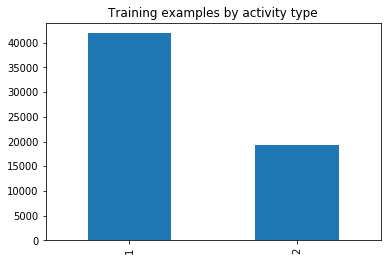

In [6]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [7]:
N_TIME_STEPS = 500
N_FEATURES = 6
step = 100
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
    ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
    zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #print label
    segments.append([xs, ys, zs, xsg, ysg, zsg])
    labels.append(label)
    #print labels

In [8]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [9]:
reshaped_segments.shape

(607, 500, 6)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [11]:
X_train.shape

(485, 500, 6)

In [12]:
X_test.shape

(122, 500, 6)

In [13]:
N_CLASSES = 2
N_HIDDEN_UNITS = 64

In [14]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden =tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [15]:
#tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [16]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [17]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [18]:
LEARNING_RATE = 0.00025
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [19]:
N_EPOCHS = 40
BATCH_SIZE = 128

In [20]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
    #if i != 1 and i % 10 != 0:
        #continue

    print("epoch " + str(i) + ":  "+ "test accuracy:" + " " + str(acc_test) + " " + "loss:" + str(loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

#print()
print("final results: accuracy:   " + str(acc_final) + "\t" +  "loss:  " +str(loss_final))

epoch 1:  test accuracy: 0.647541 loss:1.3926578
epoch 2:  test accuracy: 0.7295082 loss:1.3199575
epoch 3:  test accuracy: 0.76229507 loss:1.2874345
epoch 4:  test accuracy: 0.7704918 loss:1.2381911
epoch 5:  test accuracy: 0.7704918 loss:1.2028558
epoch 6:  test accuracy: 0.78688526 loss:1.1665871
epoch 7:  test accuracy: 0.78688526 loss:1.1424291
epoch 8:  test accuracy: 0.8278689 loss:1.1152234
epoch 9:  test accuracy: 0.8442623 loss:1.1019225
epoch 10:  test accuracy: 0.8442623 loss:1.0982836
epoch 11:  test accuracy: 0.852459 loss:1.0876733
epoch 12:  test accuracy: 0.8606557 loss:1.0705447
epoch 13:  test accuracy: 0.8606557 loss:1.0551105
epoch 14:  test accuracy: 0.86885244 loss:1.0269312
epoch 15:  test accuracy: 0.8770492 loss:1.0154033
epoch 16:  test accuracy: 0.8852459 loss:0.99874914
epoch 17:  test accuracy: 0.90163934 loss:0.9922472
epoch 18:  test accuracy: 0.90163934 loss:0.96596205
epoch 19:  test accuracy: 0.90163934 loss:0.9804788
epoch 20:  test accuracy: 0.90163

In [21]:
pickle.dump(predictions, open("predictions_act2.p", "wb"))
pickle.dump(history, open("history_act2.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/activity_2.pbtxt')  
saver.save(sess, save_path = "./checkpoint/activity_2.ckpt")
sess.close()

In [22]:
history = pickle.load(open("history_act2.p", "rb"))
predictions = pickle.load(open("predictions_act2.p", "rb"))

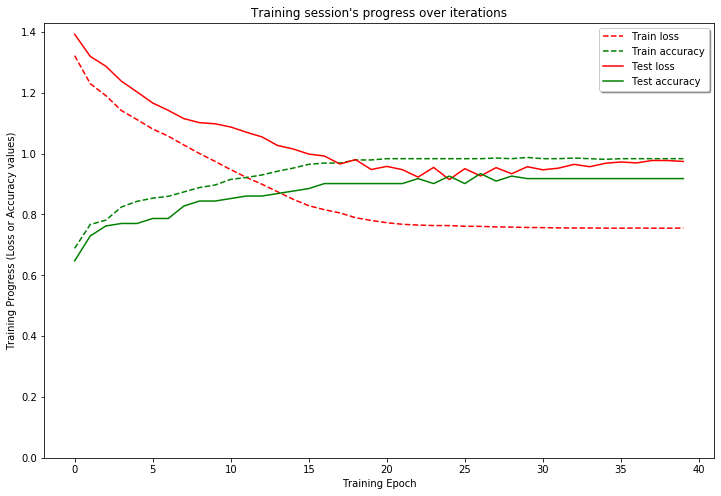

In [23]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [24]:
#activity
LABELS = [1,2]

In [25]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [26]:
#max_test = np.argmax(y_test, axis=1)
#ls = list(max_test)
#ls


In [27]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

max_test1 = max_test.tolist()
print (max_test1)
print (len(max_test1))
max_predictions1 = max_predictions.tolist()
print(max_predictions1)
print(len(max_predictions1))

confusion_matrix(max_test1, max_predictions1)


[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
122
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
122


array([[85,  1],
       [ 9, 27]])

In [28]:
def data_reshaping(df):
    #df['activity'].value_counts().plot(kind='bar', title='Testing examples by activity type');
    N_TIME_STEPS = 500
    N_FEATURES = 6
    step = 100
    segments = []
    test_labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        xs = df['x-axis'].values[i: i + N_TIME_STEPS]
        ys = df['y-axis'].values[i: i + N_TIME_STEPS]
        zs = df['z-axis'].values[i: i + N_TIME_STEPS]
        xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
        ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
        zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
        
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs, xsg, ysg,zsg])
        test_labels.append(label)
    #print test_labels
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
    #test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.float32)
    #X_train, X_test, y_train, y_test = train_test_split(
        #reshaped_segments, test_labels, test_size=0.99, random_state=RANDOM_SEED)
    X_test = reshaped_segments
    y_test = test_labels
    
    #print test_labels
    return X_test, y_test
    

In [47]:
columns1=['ep','x-axis', 'y-axis' ,'z-axis' ,'xg-axis' ,'yg-axis' ,'zg-axis']
test = pd.read_csv('Act3.csv', header = None, names = columns1)
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis
0,1.575019e+12,-0.0505,-0.2781,0.9808,-3.2317,-41.9512,25.6098
1,1.575019e+12,0.0529,-0.2877,1.0481,1.5244,-58.3537,23.0488
2,1.575019e+12,0.1602,-0.3036,1.1130,6.8902,-74.8781,20.9146
3,1.575019e+12,0.2148,-0.2762,1.0878,7.7439,-74.2073,21.0366
4,1.575019e+12,0.1478,-0.2401,1.0536,3.2317,-58.4146,24.2073
...,...,...,...,...,...,...,...
33182,1.575020e+12,-0.6005,0.2426,0.6189,-33.5366,35.9146,34.8780
33183,1.575020e+12,-0.7245,0.2074,0.5172,-50.6098,83.2927,34.0244
33184,1.575020e+12,-0.6721,0.1356,0.4810,-70.3659,115.4268,29.3902
33185,1.575020e+12,-0.8745,0.0027,0.3329,-81.3415,126.7073,26.1585


In [48]:
test['activity']=1

In [49]:
test

,ep,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,1.575019e+12,-0.0505,-0.2781,0.9808,-3.2317,-41.9512,25.6098,1
1,1.575019e+12,0.0529,-0.2877,1.0481,1.5244,-58.3537,23.0488,1
2,1.575019e+12,0.1602,-0.3036,1.1130,6.8902,-74.8781,20.9146,1
3,1.575019e+12,0.2148,-0.2762,1.0878,7.7439,-74.2073,21.0366,1
4,1.575019e+12,0.1478,-0.2401,1.0536,3.2317,-58.4146,24.2073,1
...,...,...,...,...,...,...,...,...
33182,1.575020e+12,-0.6005,0.2426,0.6189,-33.5366,35.9146,34.8780,1
33183,1.575020e+12,-0.7245,0.2074,0.5172,-50.6098,83.2927,34.0244,1
33184,1.575020e+12,-0.6721,0.1356,0.4810,-70.3659,115.4268,29.3902,1
33185,1.575020e+12,-0.8745,0.0027,0.3329,-81.3415,126.7073,26.1585,1


In [50]:
x_test1, y_test1 = data_reshaping(test)

In [51]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver = tf.train.import_meta_graph("./checkpoint/activity_2.ckpt.meta")
    saver.restore(sess,tf.train.latest_checkpoint("./checkpoint"))
    predictions1= sess.run(pred_softmax, feed_dict={X: x_test1})
    #predictions, acc_final, loss_final = sess.run([pred_softmax, a, feed_dict={X: X_test1, Y: y_test1})
    sess.close()

INFO:tensorflow:Restoring parameters from ./checkpoint/activity_2.ckpt


In [52]:
y_ls = list(y_test1)
print(y_ls)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [53]:
max_predictions1 = np.argmax(predictions1, axis=1) + 1
print(len(list(max_predictions1)))
print((max_predictions1))

327
[2 1 2 2 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 1 1 2 2 1 2 2
 2 2 2 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 2 2 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 1 1 2 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 1 1 1 1 2 2 2 2 2 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [54]:
a=confusion_matrix(y_ls, max_predictions1)
print(a)
accuracy = ((a[0][1])*100)/(len(max_predictions1))
print(accuracy)

[[202 125]
 [  0   0]]
38.2262996941896
